# MatrixMatch

In [1]:
import time
begin_start_time = time.time()
time_str = time.strftime('%Y-%m-%d %H-%M-%S', time.localtime(begin_start_time))
print(time_str)

2025-11-25 18-22-45


In [2]:
import torch, pandas as pd, os
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cuda


In [3]:
from PPO.ppo_agent_eval import head_to_head, plot_winrate_bar
from pprint import pprint
import matplotlib.pyplot as plt
from DQN.h2h_to_excel import append_h2h_to_excel
import numpy as np

In [4]:
# Cell 3: round-robin matrix match helper

def run_round_robin_matrix(
    checkpoints,
    n_games=100,
    opening_noise_k=0,
    base_seed=666,
    progress=True,
):
    """
    Run all-vs-all matches using ppo_agent_eval.head_to_head.

    Returns:
      score_df   : DataFrame [A,B] = score(A vs B) in [0,1]
      meta_score : Series, average score vs all others (row-wise mean)
      matches_df : flat table similar to your earlier summary
    """
    names = list(checkpoints)
    n = len(names)

    score_mat = np.zeros((n, n), dtype=float)
    np.fill_diagonal(score_mat, 0.5)   # convenience; ignored in meta-score

    rows = []
    pair_seed = base_seed

    for i, A in enumerate(names):
        for j, B in enumerate(names):
            if i == j: continue
            if j < i:
                # we already did B vs A; reuse symmetry
                score_mat[i, j] = 1.0 - score_mat[j, i]
                continue

            print(f"\n=== Match {A} (A) vs {B} (B) ===")
            res = head_to_head(
                ckptA=A,
                ckptB=B,
                n_games=n_games,
                opening_noise_k=opening_noise_k,
                seed=pair_seed,
                progress=progress,
            )
            pair_seed += 1

            score = float(res["A_score_rate"])
            lo, hi = res["A_score_CI95"]

            # fill matrix
            score_mat[i, j] = score
            score_mat[j, i] = 1.0 - score

            # flat table row
            rows.append({
                "Games":   int(res["games"]),
                "A_path":  A,
                "B_path":  B,
                "A_wins":  int(res["A_wins"]),
                "A_loses": int(res["A_losses"]),
                "draws":   int(res["draws"]),
                "A-score": score,
                "95% CI":  f"{lo:.3f}–{hi:.3f}",
            })

    score_df = pd.DataFrame(score_mat, index=names, columns=names)

    # meta-score: average over row (excluding self)
    meta_score = score_df.copy()
    np.fill_diagonal(meta_score.values, np.nan)
    meta_score = meta_score.mean(axis=1, skipna=True)

    matches_df = pd.DataFrame(rows)

    return score_df, meta_score, matches_df

def print_hof_dict(df, name="HOF_METASCORES", col="meta_score", digits=3):
    lines = [f"{name} = {{"]
    for key, val in df[col].items():
        lines.append(f'    "{key}": {val:.{digits}f},')
    lines.append("}")
    print("\n".join(lines))


In [5]:
# Cell 2: config

# Base names or full paths; if no suffix, ppo_agent_eval will append " PPO model.pt"
CHECKPOINTS = [
    "RND_27b" ,
    "RND_29" ,
    "RND_30" ,
    "RND_31",
    "RND_32",
    "RND_33",
    "RND_34",
    "RND_35",
    "RND_36",
]

challenger =[ 
    "DIST_XII",
    "DIST_XIII",
]

if len(challenger): CHECKPOINTS.extend(challenger)

N_GAMES_PER_MATCH = 200       
OPENING_NOISE_K   = 0           
BASE_SEED         = 666         
SHOW_PROGRESS     = True        
print("Used:", len(CHECKPOINTS))


Used: 11


In [6]:
score_df, meta_score, matches_df = run_round_robin_matrix(
    CHECKPOINTS,
    n_games=N_GAMES_PER_MATCH,
    opening_noise_k=OPENING_NOISE_K,
    base_seed=BASE_SEED,
    progress=SHOW_PROGRESS,
)

print("\n=== Pairwise results ===")
display(matches_df)

print("\n=== Meta-score ranking (higher is better) ===")
ranking = meta_score.sort_values(ascending=False).to_frame("meta_score")
display(ranking)



=== Match RND_27b (A) vs RND_29 (B) ===


RND_27b vs RND_29:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_27b (A) vs RND_30 (B) ===


RND_27b vs RND_30:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_27b (A) vs RND_31 (B) ===


RND_27b vs RND_31:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_27b (A) vs RND_32 (B) ===


RND_27b vs RND_32:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_27b (A) vs RND_33 (B) ===


RND_27b vs RND_33:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_27b (A) vs RND_34 (B) ===


RND_27b vs RND_34:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_27b (A) vs RND_35 (B) ===


RND_27b vs RND_35:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_27b (A) vs RND_36 (B) ===


RND_27b vs RND_36:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_27b (A) vs DIST_XII (B) ===


RND_27b vs DIST_XII:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_27b (A) vs DIST_XIII (B) ===


RND_27b vs DIST_XIII:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_29 (A) vs RND_30 (B) ===


RND_29 vs RND_30:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_29 (A) vs RND_31 (B) ===


RND_29 vs RND_31:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_29 (A) vs RND_32 (B) ===


RND_29 vs RND_32:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_29 (A) vs RND_33 (B) ===


RND_29 vs RND_33:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_29 (A) vs RND_34 (B) ===


RND_29 vs RND_34:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_29 (A) vs RND_35 (B) ===


RND_29 vs RND_35:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_29 (A) vs RND_36 (B) ===


RND_29 vs RND_36:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_29 (A) vs DIST_XII (B) ===


RND_29 vs DIST_XII:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_29 (A) vs DIST_XIII (B) ===


RND_29 vs DIST_XIII:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_30 (A) vs RND_31 (B) ===


RND_30 vs RND_31:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_30 (A) vs RND_32 (B) ===


RND_30 vs RND_32:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_30 (A) vs RND_33 (B) ===


RND_30 vs RND_33:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_30 (A) vs RND_34 (B) ===


RND_30 vs RND_34:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_30 (A) vs RND_35 (B) ===


RND_30 vs RND_35:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_30 (A) vs RND_36 (B) ===


RND_30 vs RND_36:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_30 (A) vs DIST_XII (B) ===


RND_30 vs DIST_XII:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_30 (A) vs DIST_XIII (B) ===


RND_30 vs DIST_XIII:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_31 (A) vs RND_32 (B) ===


RND_31 vs RND_32:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_31 (A) vs RND_33 (B) ===


RND_31 vs RND_33:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_31 (A) vs RND_34 (B) ===


RND_31 vs RND_34:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_31 (A) vs RND_35 (B) ===


RND_31 vs RND_35:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_31 (A) vs RND_36 (B) ===


RND_31 vs RND_36:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_31 (A) vs DIST_XII (B) ===


RND_31 vs DIST_XII:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_31 (A) vs DIST_XIII (B) ===


RND_31 vs DIST_XIII:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_32 (A) vs RND_33 (B) ===


RND_32 vs RND_33:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_32 (A) vs RND_34 (B) ===


RND_32 vs RND_34:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_32 (A) vs RND_35 (B) ===


RND_32 vs RND_35:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_32 (A) vs RND_36 (B) ===


RND_32 vs RND_36:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_32 (A) vs DIST_XII (B) ===


RND_32 vs DIST_XII:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_32 (A) vs DIST_XIII (B) ===


RND_32 vs DIST_XIII:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_33 (A) vs RND_34 (B) ===


RND_33 vs RND_34:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_33 (A) vs RND_35 (B) ===


RND_33 vs RND_35:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_33 (A) vs RND_36 (B) ===


RND_33 vs RND_36:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_33 (A) vs DIST_XII (B) ===


RND_33 vs DIST_XII:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_33 (A) vs DIST_XIII (B) ===


RND_33 vs DIST_XIII:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_34 (A) vs RND_35 (B) ===


RND_34 vs RND_35:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_34 (A) vs RND_36 (B) ===


RND_34 vs RND_36:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_34 (A) vs DIST_XII (B) ===


RND_34 vs DIST_XII:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_34 (A) vs DIST_XIII (B) ===


RND_34 vs DIST_XIII:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_35 (A) vs RND_36 (B) ===


RND_35 vs RND_36:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_35 (A) vs DIST_XII (B) ===


RND_35 vs DIST_XII:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_35 (A) vs DIST_XIII (B) ===


RND_35 vs DIST_XIII:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_36 (A) vs DIST_XII (B) ===


RND_36 vs DIST_XII:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match RND_36 (A) vs DIST_XIII (B) ===


RND_36 vs DIST_XIII:   0%|          | 0/200 [00:00<?, ?it/s]


=== Match DIST_XII (A) vs DIST_XIII (B) ===


DIST_XII vs DIST_XIII:   0%|          | 0/200 [00:00<?, ?it/s]


=== Pairwise results ===


,Games,A_path,B_path,A_wins,A_loses,draws,A-score,95% CI
0,200,RND_27b,RND_29,0,200,0,0.00,0.000–0.000
1,200,RND_27b,RND_30,200,0,0,1.00,1.000–1.000
2,200,RND_27b,RND_31,200,0,0,1.00,1.000–1.000
3,200,RND_27b,RND_32,100,100,0,0.50,0.431–0.569
4,200,RND_27b,RND_33,100,100,0,0.50,0.431–0.569
5,200,RND_27b,RND_34,100,100,0,0.50,0.431–0.569
6,200,RND_27b,RND_35,100,100,0,0.50,0.431–0.569
7,200,RND_27b,RND_36,0,200,0,0.00,0.000–0.000
8,200,RND_27b,DIST_XII,100,100,0,0.50,0.431–0.569
9,200,RND_27b,DIST_XIII,100,100,0,0.50,0.431–0.569



=== Meta-score ranking (higher is better) ===


,meta_score
DIST_XIII,0.700
RND_34,0.600
RND_36,0.600
RND_33,0.550
RND_32,0.550
RND_27b,0.500
RND_35,0.500
DIST_XII,0.425
RND_30,0.375
RND_29,0.350


In [7]:
print_hof_dict(ranking)

HOF_METASCORES = {
    "DIST_XIII": 0.700,
    "RND_34": 0.600,
    "RND_36": 0.600,
    "RND_33": 0.550,
    "RND_32": 0.550,
    "RND_27b": 0.500,
    "RND_35": 0.500,
    "DIST_XII": 0.425,
    "RND_30": 0.375,
    "RND_29": 0.350,
    "RND_31": 0.350,
}


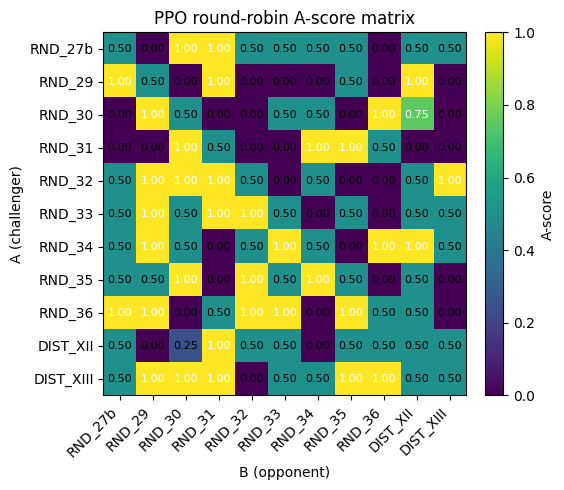

In [8]:
# Cell 5: heatmap of A-score vs B

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(score_df.values, vmin=0.0, vmax=1.0)

ax.set_xticks(np.arange(len(score_df.columns)))
ax.set_yticks(np.arange(len(score_df.index)))
ax.set_xticklabels(score_df.columns, rotation=45, ha="right")
ax.set_yticklabels(score_df.index)

ax.set_xlabel("B (opponent)")
ax.set_ylabel("A (challenger)")
ax.set_title("PPO round-robin A-score matrix")

# annotate cells
for i in range(score_df.shape[0]):
    for j in range(score_df.shape[1]):
        val = score_df.iat[i, j]
        ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=8, color="white" if val > 0.6 else "black")

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="A-score")
fig.tight_layout()
plt.show()


In [9]:
# Cell 6: optional export

OUT_DIR = "Logs/PPO_matrix/"
os.makedirs(OUT_DIR, exist_ok=True)

score_df.to_excel(os.path.join(OUT_DIR, "matrix_scores.xlsx"))
matches_df.to_excel(os.path.join(OUT_DIR, "pairwise_matches.xlsx"), index=False)
ranking.to_excel(os.path.join(OUT_DIR, "meta_ranking.xlsx"))
print("Saved matrix / matches / ranking to", OUT_DIR)


Saved matrix / matches / ranking to Logs/PPO_matrix/


In [10]:
end_time = time.time()
total_elapsed = (end_time - begin_start_time) / 60
print(f"Evaluation completed in {total_elapsed:.1f} minutes")

Evaluation completed in 3.0 minutes
